# Exploratory Data Analysis

Here, we explore the MAGIC gamma-ray data, build initial models. Exploratory data analysis includes visualization of the feauture distributions along with their correlation with the target. We also investigate correlation among features. We train three different classifiers, two of which establish a baseline performance; the other will be used as the proposed model.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
TRAIN_DATA_FILE_NAME = '../data/train.csv'
TEST_DATA_FILE_NAME = '../data/test.csv'

In [3]:
train_data =  pd.read_csv(TRAIN_DATA_FILE_NAME)
train_data.head()

,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,24.6014,12.8664,2.3793,0.5637,0.2985,17.3748,19.5657,8.2758,22.8210,216.9520,g
1,49.9223,22.3316,3.2930,0.2363,0.1210,6.7223,51.4013,-12.9949,6.8500,240.1190,g
2,28.1635,15.8070,2.4200,0.4259,0.2490,-17.9803,-13.7842,-8.3405,17.1252,248.0300,g
3,138.3880,44.5241,3.2860,0.0949,0.0674,-71.2351,66.0265,-48.3917,45.0480,250.2907,h
4,80.7882,55.0349,3.4713,0.1449,0.0725,31.8274,70.9064,58.1480,22.5290,277.3980,g


## Pair plots

Below we plot feature distributions compared against each other and their correlation with the target variable. The plot below does indicate a degree of correlation between some of our features, most notably `Conc` and `Conc1`. Correlation will not necessarily be a concern for the models built here, but would be a problem if we were interested in investigating feature importance. The univariate distributions plotted on the diagonal do not indicate any particularly strong correlation between individual features and the target. This suggests a well-performing model will likely need to leverage multiple features simultaneously to make predictions.

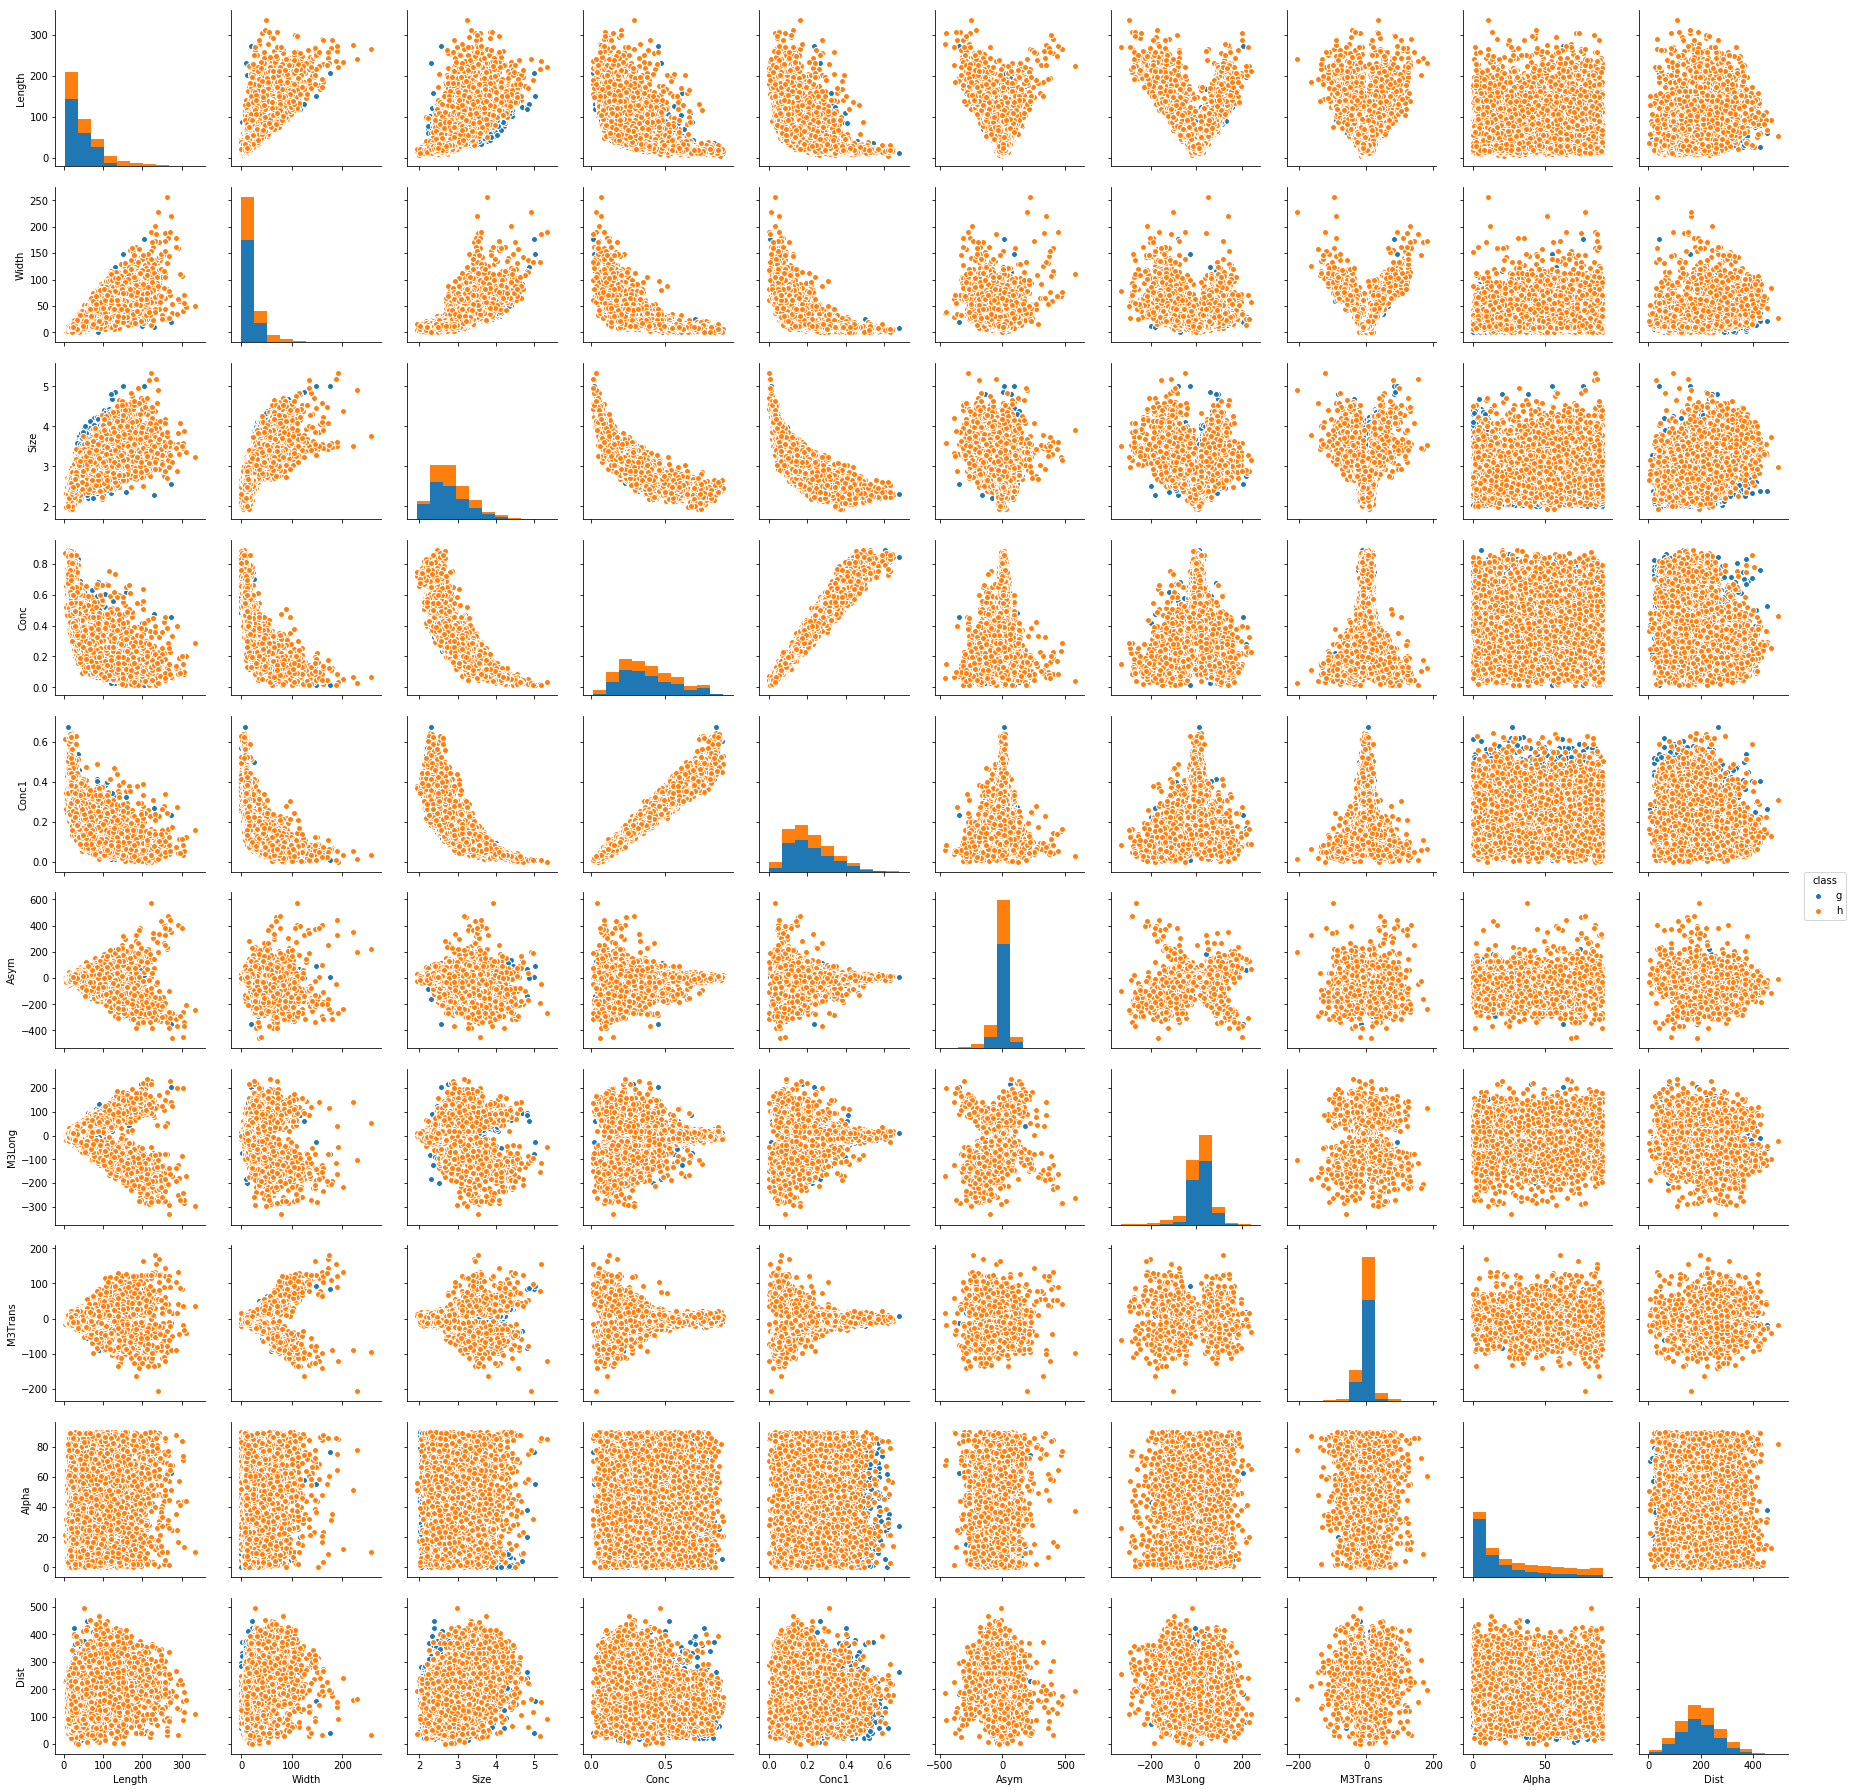

In [4]:
sns.pairplot(train_data, hue='class')

## Pearson correlation

Below we compute and visualize the Pearson correlation coefficients of our feature variables. As seen in the previous plot, the `Conc` and `Conc1` features are highly correlated. Because we are not specifically interested in determining feature importance here, we note the correlation, but keep both features in our training data set.

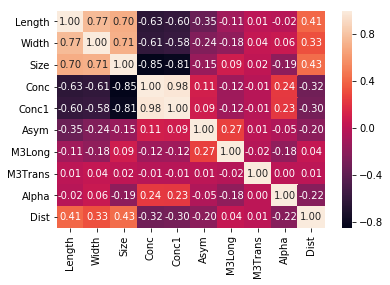

In [5]:
correlation_columns = train_data.columns.drop('class')
sns.heatmap(train_data[correlation_columns].corr(), annot=True, fmt=".2f")

## Class imbalance

The target distribution of this data set is approximately 2:1 gamma rays to hadrons. Below we confirm that the random split we have performed to generate our tests set has maintained this class imbalance.

In [6]:
(train_data['class'] == 'g').mean()

0.6487907465825447

In [7]:
X = train_data[correlation_columns]
y = train_data['class'] == 'g'

## Feature scaling

For the k-nearest neighbors and logistic regression algorithms trained below, features must be scaled so that they are distributed over approximately the same range of values. We can see from the pair plot above that the `Conc` feature, for example, lies in a range of about 0 to 1, whereas the `Dist` feature lies in a range from 0 to 500. Left unadjusted, these types of discrepancies will lead to poor performance of the k-nearest neighbors and logistic regression algorithms. However, this is not an issue for the tree-based gradient boosting classifier algorithm.

In [8]:
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

## K-nearest neighbors

Below we train a k-nearest neighbors classifier. We optimize the `n_neighbors` hyperparameter using 4-fold cross validation. While the range of values explored by the `param_grid` seem quite narrow, these were arrived upon iteratively by first exploring a broader range of values. The results of the grid search indicate that the k-nearest neighbors algorithm performs surprisingly well. The optimal mean test AUC of just under 0.9 was achieved using 37 neighbors. 

In [9]:
param_grid = {'n_neighbors': [30, 33, 35, 37, 40, 43, 45]}
knn_model = KNeighborsClassifier()
gscv_knn = GridSearchCV(knn_model, param_grid, scoring='roc_auc', cv=4, return_train_score=True)
gscv_knn.fit(X_scaled, y)
pd.DataFrame(gscv_knn.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.009184,0.276189,0.896419,0.917977,30,{'n_neighbors': 30},5,0.894531,0.918641,0.901095,0.915577,0.899483,0.917478,0.890567,0.920210,0.001152,0.006985,0.004155,0.001691
1,0.008526,0.286085,0.896391,0.916230,33,{'n_neighbors': 33},7,0.896002,0.916580,0.900596,0.913694,0.898885,0.915742,0.890083,0.918905,0.000118,0.003632,0.003995,0.001867
2,0.008030,0.289457,0.896411,0.915355,35,{'n_neighbors': 35},6,0.896336,0.915755,0.900094,0.912972,0.899158,0.914808,0.890056,0.917883,0.000169,0.005167,0.003921,0.001770
3,0.008107,0.306432,0.896947,0.914473,37,{'n_neighbors': 37},1,0.896779,0.914989,0.900325,0.912052,0.900454,0.913741,0.890231,0.917110,0.000282,0.018644,0.004148,0.001845
4,0.008711,0.327103,0.896596,0.913430,40,{'n_neighbors': 40},4,0.896575,0.913921,0.899806,0.911747,0.900044,0.912203,0.889958,0.915850,0.000626,0.007452,0.004070,0.001615
5,0.008142,0.311854,0.896605,0.912276,43,{'n_neighbors': 43},3,0.896945,0.913108,0.898706,0.910667,0.900279,0.910872,0.890491,0.914458,0.000249,0.004281,0.003722,0.001582
6,0.008068,0.319749,0.896607,0.911517,45,{'n_neighbors': 45},2,0.897428,0.912220,0.898477,0.909799,0.900339,0.910167,0.890183,0.913882,0.000188,0.006767,0.003852,0.001648


## Logistic regression

Below we train a logistic regression classifier. We optimize the L2 regularization strength hyperparameter `C` using 4-fold cross validation. Logistic regression performs substantially worse than k-nearest neighbors, which may be due to what we discovered in the pairwise plots above: individual features do not distinguish the target very well. We see below that performance is independent of regularization strength probably because our model includes so few features. The logistic model consistently performs at just under 0.84 AUC.

In [10]:
param_grid = {'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]}
logistic_model = LogisticRegression(solver='lbfgs')
gscv_logistic = GridSearchCV(logistic_model, param_grid, scoring='roc_auc', cv=4, return_train_score=True)
gscv_logistic.fit(X_scaled, y)
pd.DataFrame(gscv_logistic.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.019116,0.001353,0.838957,0.839396,0.01,{'C': 0.01},8,0.843581,0.836922,0.841272,0.838956,0.841500,0.839099,0.829475,0.842608,0.002433,0.000029,0.005548,0.002045
1,0.018411,0.001494,0.839174,0.839652,0.03,{'C': 0.03},1,0.843744,0.837213,0.841486,0.839150,0.842230,0.839276,0.829234,0.842967,0.000873,0.000182,0.005796,0.002081
2,0.018779,0.001314,0.839095,0.839600,0.1,{'C': 0.1},2,0.843692,0.837143,0.841391,0.839081,0.842347,0.839185,0.828948,0.842992,0.000292,0.000021,0.005915,0.002120
3,0.018246,0.001296,0.839044,0.839544,0.3,{'C': 0.3},3,0.843648,0.837072,0.841381,0.839029,0.842316,0.839115,0.828830,0.842960,0.000495,0.000014,0.005952,0.002135
4,0.018549,0.001324,0.839006,0.839518,1,{'C': 1},4,0.843607,0.837041,0.841347,0.838995,0.842284,0.839090,0.828784,0.842945,0.000417,0.000014,0.005955,0.002141
5,0.020030,0.001352,0.838999,0.839510,3,{'C': 3},5,0.843599,0.837035,0.841346,0.838989,0.842278,0.839077,0.828774,0.842939,0.000669,0.000041,0.005958,0.002142
6,0.019738,0.001338,0.838996,0.839508,10,{'C': 10},6,0.843593,0.837033,0.841347,0.838986,0.842274,0.839075,0.828771,0.842937,0.000515,0.000035,0.005957,0.002141
7,0.019049,0.001324,0.838994,0.839507,30,{'C': 30},7,0.843590,0.837032,0.841348,0.838987,0.842270,0.839074,0.828768,0.842935,0.000765,0.000045,0.005957,0.002141


## Gradient boosting classifer

Finally, we train a gradient boosting classifier. Using 4-fold cross validation, we optimize the `n_estimators`, `learning_rate` and `max_depth` hyperparameters. An optimal solution with mean test AUC of 0.93 is achieved using a `learning_rate` of 0.1, a `max_depth` of 5, and with 300 `n_estimators`. This model performs quite a bit better that the k-nearest neighbor model trained above. We propose this model for deployment via Amazon Sagemaker, where we will retrain using their xgboost implementation.

In [11]:
param_grid = {'n_estimators': [30, 100, 300], 'learning_rate': [0.01, 0.03, 0.1], 'max_depth': [4, 5, 6]}
gradient_boosting_model = GradientBoostingClassifier()
gscv_gbm = GridSearchCV(gradient_boosting_model, param_grid, scoring='roc_auc', cv=4, return_train_score=True)
gscv_gbm.fit(X, y)
pd.DataFrame(gscv_gbm.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,...,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.447877,0.003526,0.873630,0.883063,0.01,4,30,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",27,0.876423,...,0.873960,0.883092,0.878169,0.884342,0.865968,0.883670,0.008781,0.000048,0.004670,0.001190
1,1.432513,0.008214,0.891094,0.901871,0.01,4,100,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",24,0.892781,...,0.892398,0.901042,0.893972,0.900360,0.885225,0.903727,0.001651,0.000049,0.003438,0.001289
2,4.201932,0.020402,0.912941,0.928795,0.01,4,300,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",17,0.913304,...,0.916787,0.927122,0.916045,0.928646,0.905631,0.930210,0.018574,0.000285,0.004416,0.001116
3,0.589202,0.003959,0.885500,0.899506,0.01,5,30,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",26,0.883961,...,0.887394,0.900084,0.890756,0.900907,0.879888,0.900117,0.001887,0.000054,0.004033,0.001531
4,1.985822,0.009870,0.901950,0.917989,0.01,5,100,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",21,0.902060,...,0.904328,0.916659,0.904214,0.917399,0.897196,0.919087,0.040203,0.000200,0.002890,0.001000
5,5.752076,0.024931,0.920220,0.943683,0.01,5,300,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",14,0.920142,...,0.924515,0.942114,0.922164,0.943797,0.914057,0.944851,0.008554,0.000148,0.003880,0.000990
6,0.791994,0.004425,0.895251,0.914937,0.01,6,30,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",23,0.892644,...,0.895853,0.911283,0.900645,0.917243,0.891860,0.917101,0.004855,0.000112,0.003455,0.002450
7,2.661084,0.011852,0.910057,0.932840,0.01,6,100,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",19,0.907918,...,0.913798,0.931713,0.912524,0.933358,0.905989,0.933345,0.037211,0.000417,0.003209,0.000672
8,7.861955,0.030762,0.924854,0.957797,0.01,6,300,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",10,0.923181,...,0.930360,0.956451,0.926061,0.957911,0.919813,0.958531,0.083721,0.000628,0.003872,0.000808
9,0.435493,0.003519,0.888502,0.898776,0.03,4,30,"{'learning_rate': 0.03, 'max_depth': 4, 'n_est...",25,0.889788,...,0.890941,0.899685,0.891736,0.897502,0.881544,0.899026,0.001925,0.000044,0.004077,0.000795


## Test set performance

Below we report the performance of our three models on the holdout test set. Results are consistent with the metrics derived during hyperparameter optimization using cross validation. Our best model, a gradient boosting classifier, achieves a 0.94 AUC.

In [12]:
test_data = pd.read_csv(TEST_DATA_FILE_NAME)
X_test = test_data[correlation_columns]
y_test = test_data['class']
X_test_scaled = standard_scaler.transform(X_test)

In [13]:
test_probs_knn = gscv_knn.best_estimator_.predict_proba(X_test_scaled)
print(roc_auc_score(y_test == 'g', test_probs_knn[:, 1]))
fpr_knn, tpr_knn, thresholds = roc_curve(y_test, test_probs_knn[:, 1], pos_label='g')

0.9017545610723965


In [14]:
test_probs_logistic = gscv_logistic.best_estimator_.predict_proba(X_test_scaled)
print(roc_auc_score(y_test == 'g', test_probs_logistic[:, 1]))
fpr_logistic, tpr_logistic, thresholds = roc_curve(y_test, test_probs_logistic[:, 1], pos_label='g')

0.8381578469802556


In [15]:
test_probs_gbm = gscv_gbm.best_estimator_.predict_proba(X_test)
print(roc_auc_score(y_test == 'g', test_probs_gbm[:, 1]))
fpr_gbm, tpr_gbm, thresholds = roc_curve(y_test, test_probs_gbm[:, 1], pos_label='g')

0.9382600779132791


## Receiver operating characteristic curve

Below we plot the receiver operating characteristic (ROC) curve for the three models trained here. This plot is meant to be directly compared with Figure 5 of [Bock et al. (2004)](https://pdfs.semanticscholar.org/e02c/eb16f74be2a369b197cc9520fe480b89b94b.pdf). Black vertical lines are places at 1%, 2%, 5%, 10%, and 20% false positive rate to highlight key thresholds outlined under the Attribute Information section of the [MAGIC Gamma Telescope Data Set](https://archive.ics.uci.edu/ml/datasets/magic+gamma+telescope) site hosted by the University of California, Irvine. Our gradient boosting model outperforms all methods presented by Bock et al. (2004) at each of the required false positive thresholds.

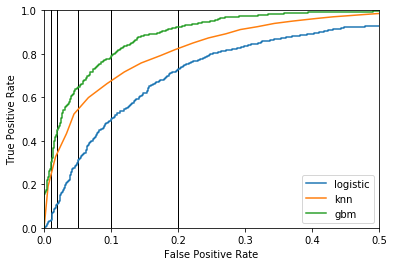

In [16]:
for fpr in [0.01, 0.02, 0.05, 0.1, 0.2]:
    plt.plot([fpr, fpr], [0, 1], 'k', lw=1)
plt.plot(fpr_logistic, tpr_logistic, label='logistic')
plt.plot(fpr_knn, tpr_knn, label='knn')
plt.plot(fpr_gbm, tpr_gbm, label='gbm')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1)
plt.xlim(0, 0.5)
plt.legend()

In [17]:
def compute_key_roc_values(df):
    df_short = pd.DataFrame(df.loc[(df['fpr'] - 0.01).abs().idxmin()]).T
    df_short = df_short.append(df.loc[(df['fpr'] - 0.02).abs().idxmin()])
    df_short = df_short.append(df.loc[(df['fpr'] - 0.05).abs().idxmin()])
    df_short = df_short.append(df.loc[(df['fpr'] - 0.1).abs().idxmin()])
    return df_short.append(df.loc[(df['fpr'] - 0.2).abs().idxmin()])

In [18]:
roc_logistic = pd.DataFrame({'fpr': fpr_logistic, 'tpr': tpr_logistic})
compute_key_roc_values(roc_logistic)

,fpr,tpr
20,0.009673,0.031707
48,0.020089,0.109756
122,0.049851,0.293902
232,0.099702,0.493089
447,0.200149,0.726829


In [19]:
roc_knn = pd.DataFrame({'fpr': fpr_knn, 'tpr': tpr_knn})
compute_key_roc_values(roc_knn)

,fpr,tpr
1,0.005952,0.190650
2,0.017113,0.326423
4,0.044643,0.523171
6,0.093750,0.662602
10,0.195685,0.819512


In [20]:
roc_gbm = pd.DataFrame({'fpr': fpr_gbm, 'tpr': tpr_gbm})
compute_key_roc_values(roc_gbm)

,fpr,tpr
26,0.009673,0.268699
52,0.020089,0.449187
128,0.049851,0.641870
238,0.099702,0.780081
426,0.199405,0.921951
